# Introduction to CREsted with Peak Regression

In this introductory notebook, we will train a peak regression model on the mouse BICCN data and inspect the results to get a feel for the capabilities of the CREsted package.  

## Import Data

For this tutorial, we will use the mouse BICCN dataset which is available in the {func}`~crested.get_dataset` function.  
To train a CREsted peak regression model on your data, you need: 
1. A consensus regions BED file containing all the regions of interest accross cell types.
2. A folder containing the bigwig files per cell type. Each file should be named according to the cell type: {cell type name}.bw.
3. A genome fasta file and optionally a chromosome sizes file.

You could use a tool like SnapATAC2 to generate the consensus regions and bigwig files from your own data.

In [1]:
import anndata as ad
import crested
import numpy as np

In [2]:
import matplotlib

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

Download the tutorial data.  
For this tutorial we will be training on the 'cut sites', but the 'coverage' data are also available (an older version of the tutorial would train on the coverage).

In [4]:
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig_cut_sites")

Or, if you have the data already available, you can specifiy the paths directly (here we created relative symlinks to our data).

In [3]:
bigwigs_folder = "data/mouse_biccn/bigwigs_cut_sites.tar.gz.untar"
regions_file = "data/mouse_biccn/consensus_peaks_biccn.bed"

By loading our genome in the {class}`crested.Genome` class and setting it with {func}`~crested.register_genome`, the genome is automatically used in all functions throughout CREsted. If you don't provide the chromomsome sizes, they will be automatically calculated from the fasta.
```{note}
Any function or class that expects a genome object can still accept a genome object as explicit input even if one was already registered. In that case, the input will be used instead of the registered genome. 
```

In [3]:
# Set the genome
genome = crested.Genome(
    "data/genomes/mm10/mm10.fa", "data/genomes/mm10/mm10.chrom.sizes"
)
crested.register_genome(
    genome
)  # Register the genome so that it can be used by the package

# you can also use this to fetch a sequence
print(genome.fetch("chr1", 10000000, 10000010))

2025-01-31T11:10:55.454785+0100 INFO Genome mm10 registered.
TTTTCAATGC


We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

In [18]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,  # optionally, use a different width than the consensus regions file (500bp) for the .X values calculation
    target="count",  # or "max", "mean", "logcount" --> what we will be predicting
)
adata

2025-01-30T10:16:31.466705+0100 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

To train a model, we always need to add a *split* column to our dataset, which we can do using {func}`crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.var` with the split type for each region (train, val, or test).

In [23]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var.head(3)

split
train    440993
val       56064
test      49936
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr1:3094805-3095305,chr1,3094805,3095305,train
chr1:3095470-3095970,chr1,3095470,3095970,train
chr1:3112174-3112674,chr1,3112174,3112674,train


## Preprocessing

### Region Width

For this example we're interested in training on wider regions than our consensus regions file (500bp) to also include some sequence information from the tails of our peaks.  

We change it to 2114 bp regions since that is what the Chrombpnet architecture was originally trained on and that's what we'll be using. This is not fixed and can be adapted to what you prefer, as long as it is compatible with the model architecture. 

Wider regions will mean that you don't only include sequence information from the center of the peaks and could effectively increase your dataset size if the tails of the peak include meaningful information, but could also introduce noise if the tails are not informative.  
Wider regions will also increase the computational cost of training the model. 

In [24]:
crested.pp.change_regions_width(
    adata,
    2114,
)  # change the adata width of the regions to 2114bp

### Peak Normalization

Additionally, we can normalize our peak values based on the variability of the top peak heights per cell type using the {func}`crested.pp.normalize_peaks` function.  

This function applies a normalization scalar to each cell type, obtained by comparing per cell type the distribution of peak heights for the maximally accessible regions which are not specific to any cell type.

In [25]:
crested.pp.normalize_peaks(
    adata, top_k_percent=0.03
)  # The top_k_percent parameters can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. Default is 0.01

2025-01-30T10:18:58.420446+0100 INFO Filtering on top k Gini scores...
2025-01-30T10:19:01.565655+0100 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr5:76656624-76658738,chr5,76656624,76658738,train
chr13:30900787-30902901,chr13,30900787,30902901,train
chr9:65586049-65588163,chr9,65586049,65588163,test
chr9:65586556-65588670,chr9,65586556,65588670,test
chr9:65587095-65589209,chr9,65587095,65589209,test
...,...,...,...,...
chr9:65459289-65461403,chr9,65459289,65461403,test
chr9:65459852-65461966,chr9,65459852,65461966,test
chr5:76587680-76589794,chr5,76587680,76589794,train


We can visualize the normalization factor for each cell type using the {func}`crested.pl.bar.normalization_weights` function to inspect which cell type peaks were up/down weighted.

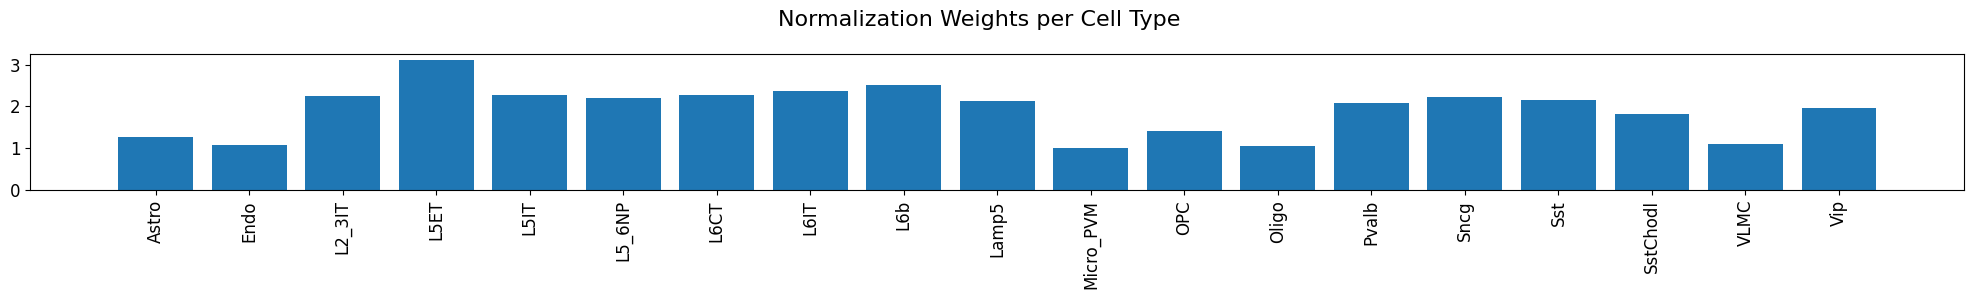

In [31]:
%matplotlib inline
crested.pl.bar.normalization_weights(
    adata, title="Normalization Weights per Cell Type", x_label_rotation=90
)

There is no single best way to preprocess your data, so we recommend experimenting with different preprocessing steps to see what works best for your data.  
Likewise there is no single best training approach, so we recommend experimenting with different training strategies.

In [32]:
# Save the final preprocessing results
adata.write_h5ad("data/mouse_cortex.h5ad")

## Model Training

The entire CREsted training workflow is built around the {func}`crested.tl.Crested` class.
Everything that requires both a model and a dataloader (training, evaluation) is done through this class.  
This class has a couple of required arguments:
- `data`: the {class}`crested.tl.data.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`keras.Model` object containing the model architecture.
- `config`: the {class}`crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.  

Generally you wouldn't run these steps in a notebook, but rather in a script or a python file so you could run it on a cluster or in the background.

### Data

We'll start by initializing the {class}`crested.tl.data.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to supply are the `adata` object, the `genome` object (if you didn't register one), and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...).

In [5]:
# read in your preprocessed data
adata = ad.read_h5ad("data/mouse_cortex.h5ad")

In [37]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=256,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional data augmentation to slightly reduce overfitting
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide your own model definition if you like.  
Alternatively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.  
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

In [38]:
# Load chrombpnet-like architecture for a dataset with 2114bp regions and 19 cell types
model_architecture = crested.tl.zoo.chrombpnet(
    seq_len=2114, num_classes=len(list(adata.obs_names))
)

I0000 00:00:1738229076.184710   11695 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5997 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`crested.tl.default_configs` function.  

In [39]:
# Load the default configuration for training a peak regression model
config = crested.tl.default_configs(
    "peak_regression"
)  # or "topic_classification" for topic classification
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x74cc8c61adb0>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x74cc99a1a960>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

In [40]:
import keras

# Create your own configuration
# I recommend trying this for peak regression with a weighted cosine mse log loss function
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
    crested.tl.metrics.ZeroPenaltyMetric(),
]

alternative_config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x74cc997ee9f0>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x74cc8c61ad20>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, checkpointing, ...).  

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

```{note}
If you specify the same project_name and run_name as a previous run, then CREsted will assume that you want to continue training and will load the last available model checkpoint from the {project_name}/{run_name} folder and continue from that epoch.
```

In [42]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=alternative_config,
    project_name="mouse_biccn",  # change to your liking
    run_name="basemodel",  # change to your liking
    logger="wandb",  # or None, 'dvc', 'tensorboard'
    seed=7,  # For reproducibility
)

In [ ]:
# train the model
trainer.fit(
    epochs=60,
    learning_rate_reduce_patience=3,
    early_stopping_patience=6,
)

2025-01-30T10:27:00.875863+0100 WARNING Model does not have an optimizer. Please compile the model before training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2025-01-30T10:27:01.153422+0100 INFO Loading sequences into memory...


100%|██████████| 440993/440993 [00:06<00:00, 63956.99it/s]


2025-01-30T10:27:08.883584+0100 INFO Loading sequences into memory...


100%|██████████| 56064/56064 [00:00<00:00, 80451.37it/s]


Epoch 1/60


I0000 00:00:1738229234.017310   14221 service.cc:148] XLA service 0x74ca1c0036a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738229234.027180   14221 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-30 10:27:14.209061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738229234.786132   14221 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 10:27:15.990437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5762', 8 bytes spill stores, 8 bytes spill loads

2025-01-30 10:27:16.156550: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5762',

### Finetuning on cell type-specific regions

#### Subsetting the consensuspeak set

For peak regression models, we recommend to continue training the model trained on all consensuspeaks on a subset of cell type-specific regions.
Since we are interested in understanding the enhancer code uniquely identifying the cell types in the dataset, finetuning on specific regions will allow us to approach that.
We define specific regions as regions with a high Gini index, indicating that their peak distribution over all cell types will be skewed and specific for one or more cell types.

Read the documentation of the {func}`crested.pp.filter_regions_on_specificity` function for more information on how the filtering is done.  

In [6]:
crested.pp.filter_regions_on_specificity(
    adata, gini_std_threshold=1.0
)  # All regions with a Gini index 1 std above the mean across all regions will be kept
adata

2025-01-30T10:30:25.115755+0100 INFO After specificity filtering, kept 91477 out of 546993 regions.


AnnData object with n_obs × n_vars = 19 × 91477
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split'
    obsm: 'weights'

In [7]:
adata.write_h5ad("data/mouse_cortex_filtered.h5ad")

#### Loading the pretrained model on all consensuspeaks and finetuning with lower learning rate

In [18]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=64,  # Recommended to go for a smaller batch size than in the basemodel
    max_stochastic_shift=3,
    always_reverse_complement=True,
)

In [19]:
# First load the pretrained model on all peaks
model_architecture = keras.models.load_model(
    "mouse_biccn/basemodel/checkpoints/17.keras",
    compile=False,  # Choose the basemodel with best validation loss/performance metrics
)

In [20]:
# Use the same config you used for the pretrained model. EXCEPT THE LEARNING RATE, make sure that is lower than it was on the epoch you select the model from.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Lower LR!
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.CosineSimilarity(axis=1),
    crested.tl.metrics.PearsonCorrelation(),
    crested.tl.metrics.ConcordanceCorrelationCoefficient(),
    crested.tl.metrics.PearsonCorrelationLog(),
    crested.tl.metrics.ZeroPenaltyMetric(),
]

alternative_config = crested.tl.TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x7f4a1665c410>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x7f4a1adafc90>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


In [21]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=alternative_config,
    project_name="mouse_biccn",  # change to your liking
    run_name="finetuned_model",  # change to your liking
    logger="wandb",  # or 'wandb', 'tensorboard'
)

2024-12-12T10:19:16.196631+0100 WARNING Output directory mouse_biccn/finetuned_model/checkpoints already exists. Will continue training from epoch 9.


In [ ]:
trainer.fit(
    epochs=60,
    learning_rate_reduce_patience=3,
    early_stopping_patience=6,
)

## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the{func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our datamodule.

In [6]:
adata = ad.read_h5ad("data/mouse_cortex_filtered.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=256,  # lower this if you encounter OOM errors
)

In [24]:
# load an existing model
evaluator = crested.tl.Crested(data=datamodule)

evaluator.load_model(
    "mouse_biccn/finetuned_model/checkpoints/02.keras",  # Load your model
    compile=True,
)

If you experimented with many different hyperparameters for your model, chances are that you will start overfitting on your validation dataset.  
It's therefore always a good idea to evaluate your model on the test set after getting good results on your validation data to see how well it generalizes to unseen data.

In [25]:
# evaluate the model on the test set
evaluator.test()

I0000 00:00:1733995238.268813 3400934 service.cc:145] XLA service 0x7f4760013af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733995238.268847 3400934 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-12-12 10:20:38.297640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-12 10:20:38.441147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 3/33 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - concordance_correlation_coefficient: 0.6685 - cosine_similarity: 0.8724 - loss: 0.5137 - mean_absolute_error: 1.6471 - mean_squared_error: 13.7273 - pearson_correlation: 0.7443 - pearson_correlation_log: 0.6123 - zero_penalty_metric: 2443.7920

I0000 00:00:1733995247.631424 3400934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - concordance_correlation_coefficient: 0.7091 - cosine_similarity: 0.8744 - loss: 0.5054 - mean_absolute_error: 1.6253 - mean_squared_error: 13.6106 - pearson_correlation: 0.7706 - pearson_correlation_log: 0.6340 - zero_penalty_metric: 2470.7397
2024-12-12T10:20:51.416834+0100 INFO Test concordance_correlation_coefficient: 0.7221
2024-12-12T10:20:51.417376+0100 INFO Test cosine_similarity: 0.8707
2024-12-12T10:20:51.417635+0100 INFO Test loss: 0.5097
2024-12-12T10:20:51.417896+0100 INFO Test mean_absolute_error: 1.6882
2024-12-12T10:20:51.418280+0100 INFO Test mean_squared_error: 14.4946
2024-12-12T10:20:51.418600+0100 INFO Test pearson_correlation: 0.7813
2024-12-12T10:20:51.418892+0100 INFO Test pearson_correlation_log: 0.6345
2024-12-12T10:20:51.419171+0100 INFO Test zero_penalty_metric: 2302.9001


### Predict

Now we have a trained model, we can use the ```crested.tl``` toolkit to run inference and explain our results. All the functionality shown below only expects a trained .keras model, meaning that you can use these functions with any model trained outside of the crested framework too.

```{warning}
An older version of crested used to handle all this functionality inside the {class}`~crested.tl.Crested` class. For ease of use, we refactored these methods to a functional form as shown below. You can still use them in its old object-method manner, but they are considered deprecated and will only be updated in its functional form.
```

The core function that you will be using is the {meth}`~crested.tl.predict` function. This expects as input something you want to predict over as well as trained model. You can even provide a list of models, as long as they expect the same input and output shapes. In that case the predictions will be averaged, which can be useful to make your predictions more robust. 

Since crested is build around making predictions over genomic sequences, this can accept as input:
- (lists of) sequence(s)
- (lists of) genomic region name(s)
- one hot encoded sequences of shape (N, L, 4)
- anndata objects with regions as its .var index

Crested will convert these inputs to its required format for the model.  
If your input is a region name or anndata, you should provide a genome as well if you did not register one.

First, we need to load a model. If you followed the tutorial you can load that one. 
If not, crested has a 'model repository' with commonly used models which you can download with 
{meth}`~crested.get_model`. You can find all example models [here](https://crested.readthedocs.io/en/latest/models/index.html).

In [28]:
# load a trained model
import keras

model = keras.models.load_model(
    "data/mouse_biccn/finetuned_model/BICCN_model_v2.keras", compile=False
)  # change to your model path

In [ ]:
# store predictions for all our regions in the anndata object for later inspection.
predictions = crested.tl.predict(adata, model)
adata.layers["biccn_model"] = predictions.T  # adata expects (C, N) instead of (N, C)

Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

#### Example predictions on test set regions

It is always interesting to see how the model performs on unseen test set regions. It is recommended to always look at a few examples to spot potential biases, or trends that you do not expect.

In [6]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var["split"] == "test"]
test_df

,chr,start,end,split
region,,,,
chr18:3269690-3271804,chr18,3269690,3271804,test
chr18:3350307-3352421,chr18,3350307,3352421,test
chr18:3451398-3453512,chr18,3451398,3453512,test
chr18:3463977-3466091,chr18,3463977,3466091,test
chr18:3488308-3490422,chr18,3488308,3490422,test
...,...,...,...,...
chr9:124125533-124127647,chr9,124125533,124127647,test
chr9:124140961-124143075,chr9,124140961,124143075,test
chr9:124142793-124144907,chr9,124142793,124144907,test


chr18:3892771-3894885
2025-01-30T13:40:16.289982+0100 INFO Plotting bar plots for region: chr18:3892771-3894885, models: ['biccn_model']


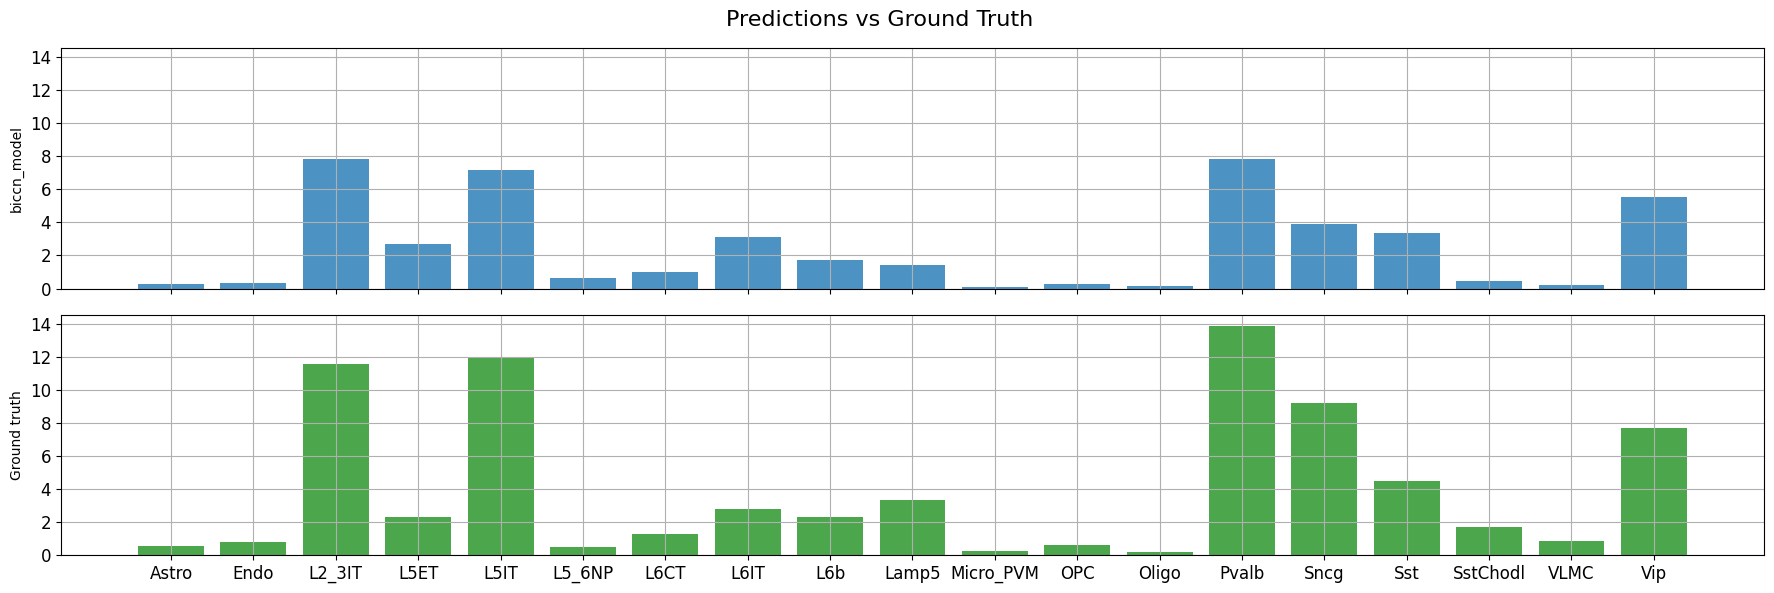

In [11]:
%matplotlib inline
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 21
region = test_df.index[idx]
print(region)
crested.pl.bar.region_predictions(adata, region, title="Predictions vs Ground Truth")

##### Example predictions on manually defined regions

In [12]:
chrom = "chr3"  #'chr18'
start = 72535878 - 807  # 61107770
end = 72536378 + 807  # 61109884

sequence = genome.fetch(chrom, start, end)

prediction = crested.tl.predict(sequence, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


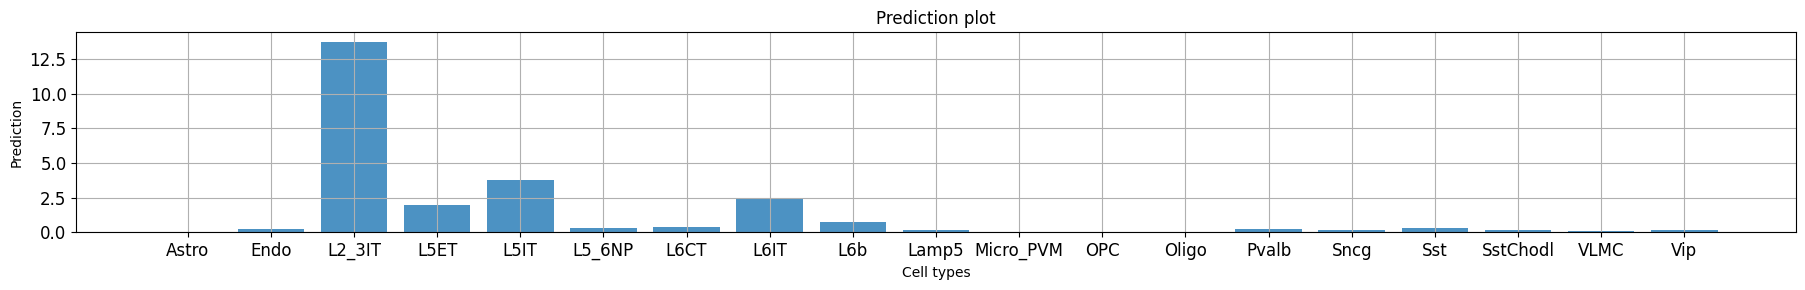

In [13]:
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

#### Prediction on gene locus

We can also score a gene locus by using a sliding window over a predefined genomic range. We can compare those predictions then to the bigwig we did the predictions for, to see if the profile matches the CREsted predictions. 

In [7]:
chrom = "chr4"
start = 91209533
end = 91374781
class_idx = list(adata.obs_names).index("Sst")

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model,
    strand="-",
    upstream=50000,
    downstream=10000,
    step_size=100,
)

70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step


In [8]:
bigwig = "data/mouse_biccn/bigwigs.tar.gz.untar/Sst.bw"
bw_values, midpoints = crested.utils.extract_bigwig_values_per_bp(bigwig, coordinates)

2025-01-30T14:13:00.258435+0100 WARNING extract_bigwig_values_per_bp() is deprecated. Please use crested.utils.read_bigwig_region(bw_file, (chr, start, end)) instead.


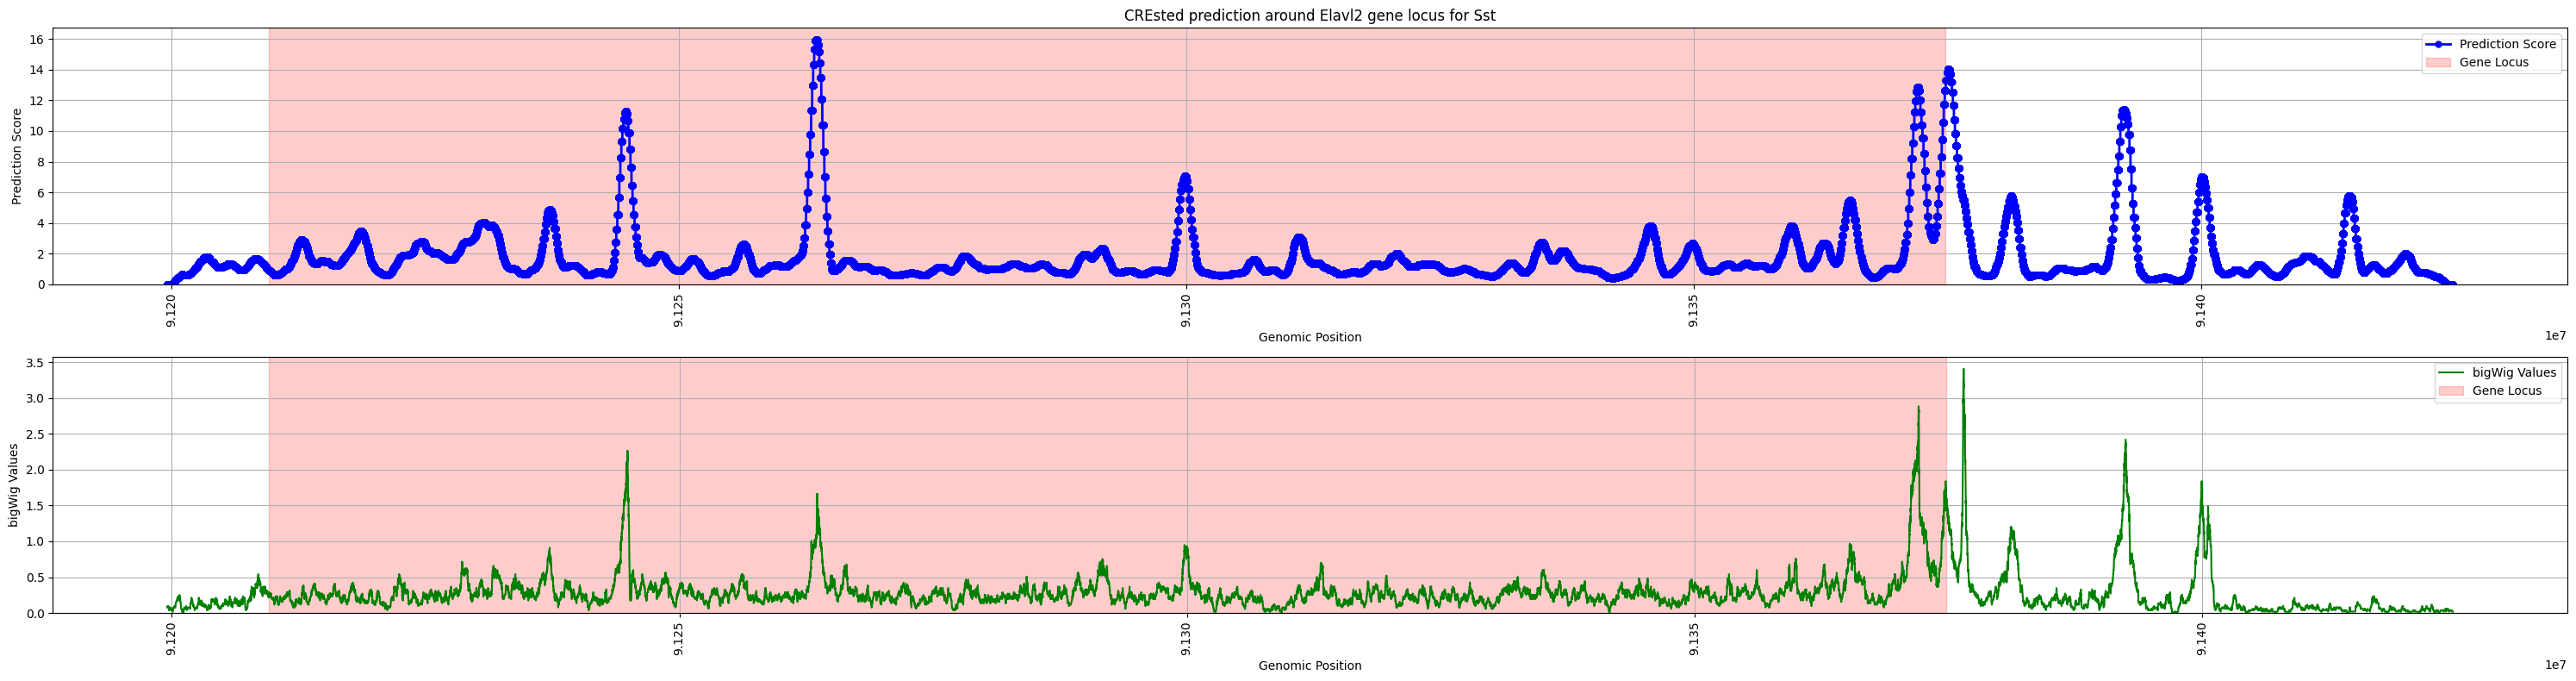

In [9]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    figsize=(30, 8),
)

#### Model performance on the entire test set

After looking at specific instances, now we can look at the model performance on a larger scale.

First, we can check per cell type/class the correlation of predictions and peak heights over the peaks in the test set.  

These plotting that show predictions over your entire dataset expect them to be saved in your `anndata.layer` object. 

2025-01-30T13:54:36.134524+0100 INFO Plotting density scatter for class: L2_3IT, models: ['biccn_model'], split: test


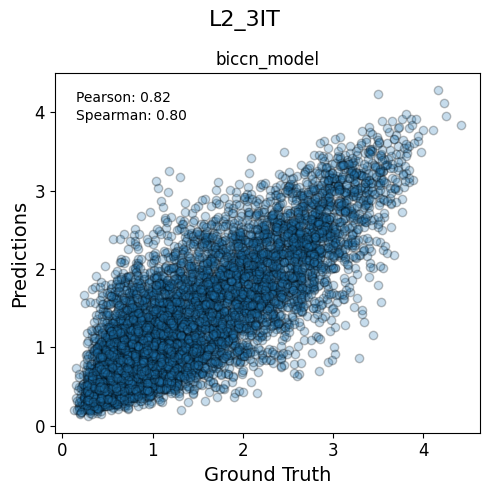

In [32]:
classn = "L2_3IT"
crested.pl.scatter.class_density(
    adata,
    class_name=classn,
    model_names=["biccn_model"],
    split="test",
    log_transform=True,
    width=5,
    height=5,
)

To now check the correlations between all classes, we can plot a heatmap to assess the model performance.

2025-01-30T13:54:41.303835+0100 INFO Plotting heatmap correlations for split: test, models: ['biccn_model']


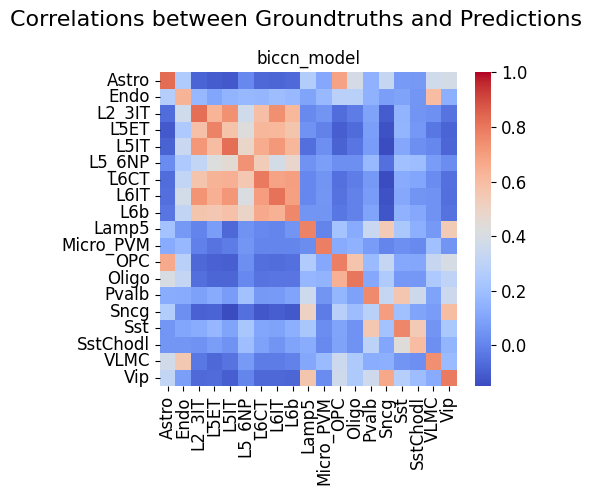

In [34]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=5,
    height=5,
    log_transform=True,
    vmax=1,
    vmin=-0.15,
)

It is also recommended to compare this heatmap to the self correlation plot of the peaks themselves. If peaks between cell types are correlated, then it is expected that predictions from non-matching classes for correlationg cell types will also be high.

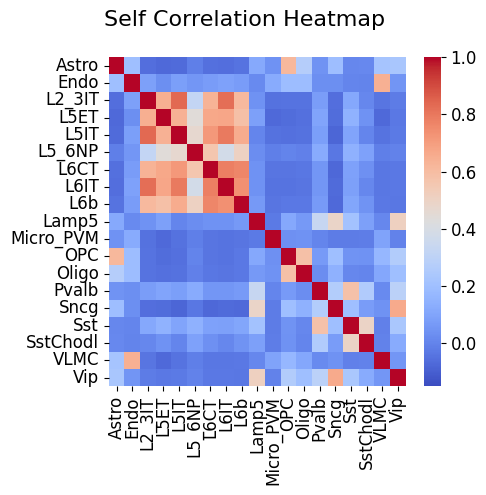

In [35]:
crested.pl.heatmap.correlations_self(
    adata,
    title="Self Correlation Heatmap",
    x_label_rotation=90,
    width=5,
    height=5,
    vmax=1,
    vmin=-0.15,
)

### Sequence contribution scores

We can calculate the contribution scores for a **sequence** of interest using the {meth}`~crested.tl.contribution_scores` function.  

This will give us information on what nucleotides the model is looking at to make its prediction with respect to a specific output class. 

You always need to ensure that the sequence or region you provide is the same length as the model input (2114bp in our case).  

Here, similar to the `predict` function, you need some input (like a sequence or region name) and a (list of) model(s). If multiple models are provided, the contribution scores will be averaged.

#### Contribution scores on manually defined sequences

In [10]:
# random sequence of length 2114bp as an example
sequence = "A" * 2114

# find the indices of the cell types of interest (Astro and Endo)
class_idx = list(adata.obs_names.get_indexer(["Astro", "Endo"]))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,  # None (=all classes), list of target indices, or empty list (='combined' class)
    model=model,
    method="expected_integrated_grad",  # default. Other options: "integrated_grad", "mutagenesis"
)

2025-01-30T14:13:10.089532+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:17<00:00, 17.38s/it]


In [11]:
print(scores.shape, one_hot_encoded_sequences.shape)

(1, 2, 2114, 4) (1, 2114, 4)


#### Contribution scores on manually defined genomic regions

In [13]:
# similar example but with region names as input
regions_of_interest = [
    "chr18:61107770-61109884"
]  # FIRE enhancer region, should only have motifs in Micro_PVM
classes_of_interest = ["Astro", "Micro_PVM", "L5ET"]
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    regions_of_interest,
    target_idx=class_idx,
    model=model,
)

2025-01-30T14:15:43.680980+0100 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:26<00:00, 26.46s/it]


Contribution scores for regions can be plotted using the {func}`crested.pl.patterns.contribution_scores` function.  
This will generate a plot per class per region.

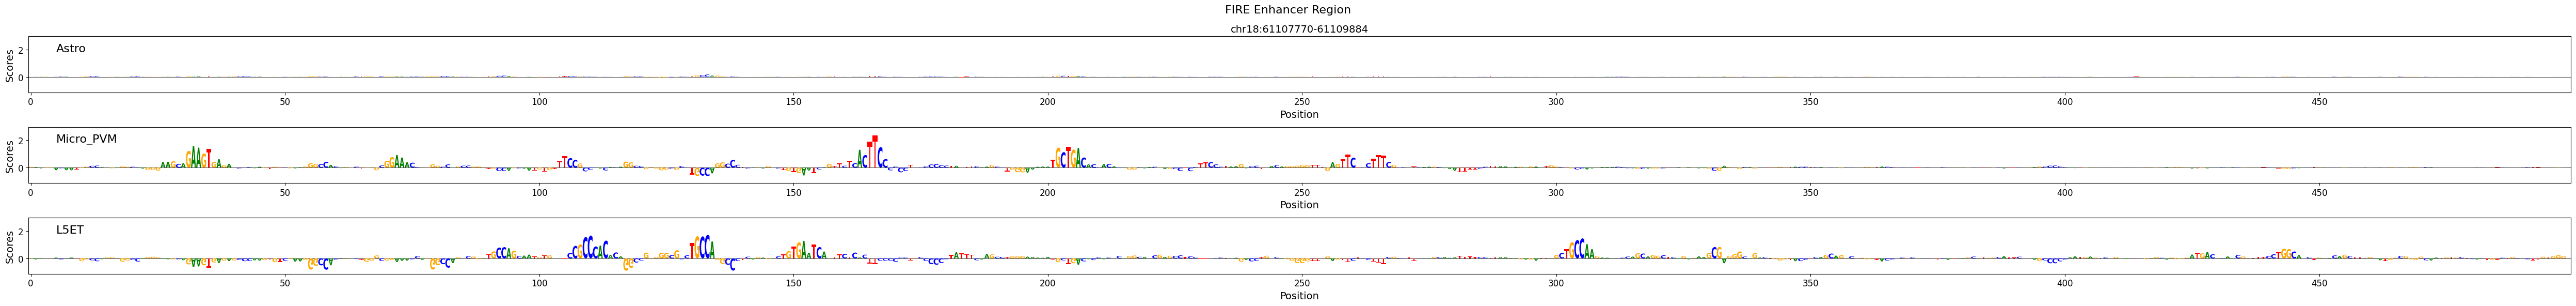

In [14]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="FIRE Enhancer Region",
)  # zoom in on the center 500bp

#### Contribution scores on random test set regions

In [17]:
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 21
region = test_df.index[idx]
classes_of_interest = ["L2_3IT", "Pvalb"]
class_idx = list(adata.obs_names.get_indexer(classes_of_interest))
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    region,
    target_idx=class_idx,
    model=model,
)

2025-01-30T14:18:14.783143+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:17<00:00, 17.35s/it]


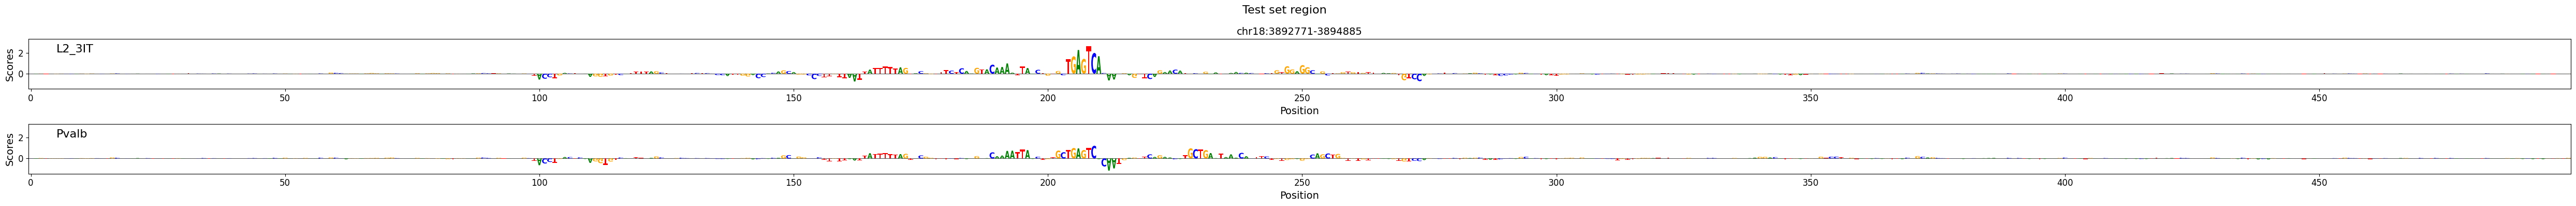

In [18]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[region],
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

## Enhancer design

Enhancer design is an important concept in understanding a cell type's cis regulatory code.  
By designing sequences to be maximally accessible for a specific cell type and inspecting those designed sequences' contribution score plots, we can get an understanding of which motifs are most important for that cell type's enhancer code. Moreover, by inspecting intermediate results throughout the optimization process, we can see which motifs and which motif positions have a comparatively higher priority.

We follow the enhancer design process as described [in this paper](https://www.nature.com/articles/s41586-023-06936-2). We start from random sequences and select at each step the nucleotide mutation or motif implementation that will lead to the largest change in accessibility for a chosen cell type.

### Sequence evolution

The standard way of designing enhancers (by making single nucleotide mutations in randomly generated regions) can be carried out using {meth}`~crested.tl.enhancer_design_in_silico_evolution`.

Before we start designing, we will calculate the nucleotide distribution of our consensus regions which will be used for creating random starting sequences (if you don't do this the design function will assume a uniform distribution). 

In [8]:
acgt_distribution = crested.utils.calculate_nucleotide_distribution(
    adata,  # accepts any sequence input, same as before
    per_position=True,  # return a distirbution per position in the sequence
)
acgt_distribution.shape

(2114, 4)

In [10]:
# we will design an enhancer for the L5ET cell type
class_idx = list(adata.obs_names).index("L5ET")

designed_sequences = crested.tl.enhancer_design_in_silico_evolution(
    model=model,
    target=class_idx,  # the default optimization function expects a target class index
    n_sequences=1,  # n enhancers to design
    n_mutations=10,  # n single nucleotide mutations to make per sequence
    target_len=500,  # only make mutations in the center 500bp
    acgt_distribution=acgt_distribution,  # if None, uniform distribution will be used
)

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


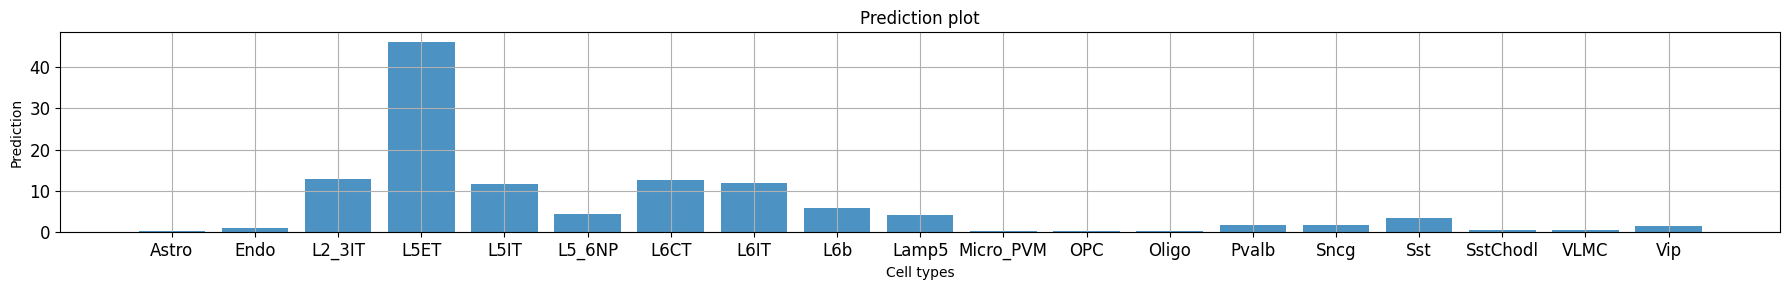

In [11]:
%matplotlib inline
# ensure that our designed sequence scores high on our target class
prediction = crested.tl.predict(designed_sequences[0], model=model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

In [12]:
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences,
    model=model,
    target_idx=class_idx,
)

2025-01-31T10:50:10.566767+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


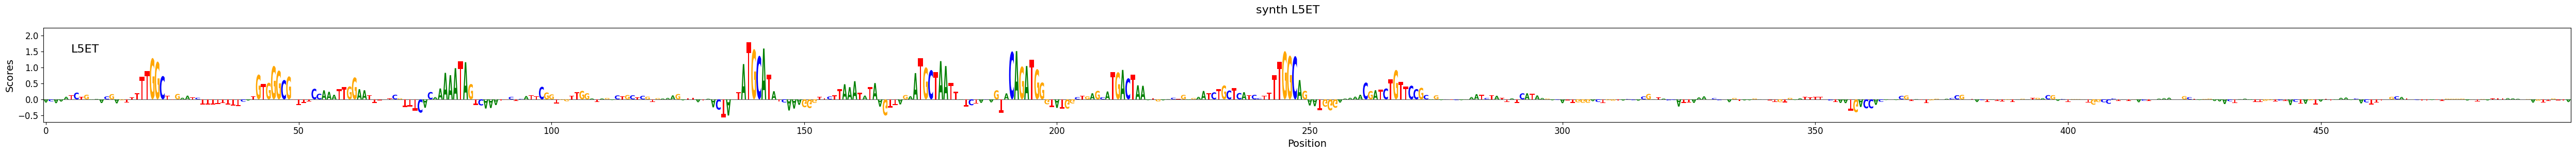

In [13]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["L5ET"],
    zoom_n_bases=500,
    title="synth L5ET",
    height=3,
)  # zoom in on the center 500bp

Keep in mind that, if you start from random sequences, enhancer design will be non-deterministic so you won't get the exact same results twice.

### Motif insertion

Another way of designing enhancers is by embedding known motifs into our sequences.  
This way, you can investigate how specific motif combinations influence a sequence's accessibility profile.
For this, you can use the {meth}`crested.tl.enhancer_design_motif_insertion` function.

In [14]:
class_idx = list(adata.obs_names).index("Oligo")

designed_sequences = crested.tl.enhancer_design_motif_insertion(
    patterns={
        "SOX10": "AACAATGGCCCCATTGT",
        "CREB5": "ATGACATCA",
    },
    target=class_idx,
    model=model,
    acgt_distribution=acgt_distribution,
    n_sequences=2,
    target_len=500,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


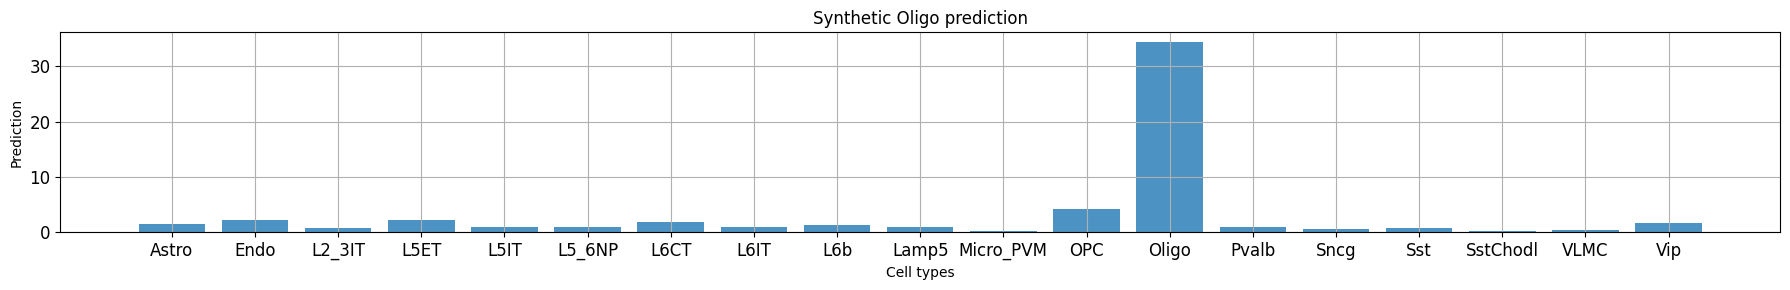

In [15]:
%matplotlib inline
# check whether our implanted motifs have the expected effect
prediction = crested.tl.predict(designed_sequences, model=model)
crested.pl.bar.prediction(
    prediction[0],
    classes=list(adata.obs_names),
    title="Synthetic Oligo prediction",
)

In [17]:
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences[1],
    target_idx=class_idx,
    model=model,
)

2025-01-31T10:51:00.438647+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


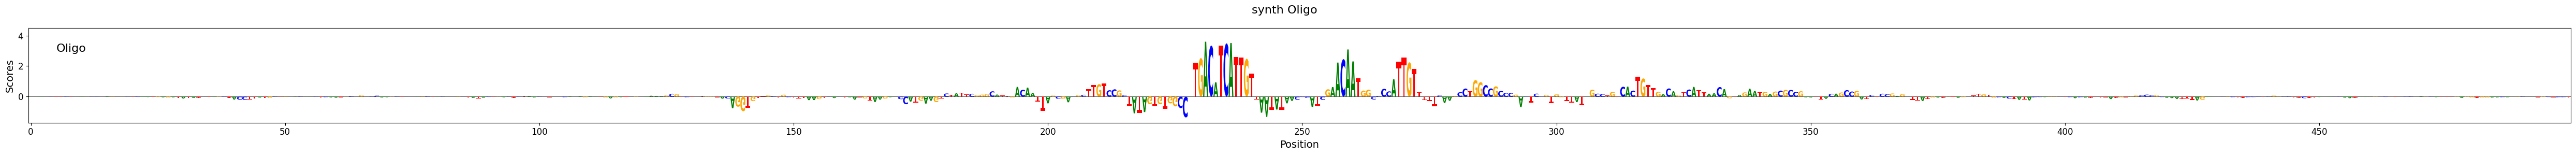

In [ ]:
%matplotlib inline
# see whether the model is actually using the implanted motifs
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["Oligo"],
    zoom_n_bases=500,
    title="synth Oligo",
    height=3,
)

### Inspecting the enhancer design process

The enhancer design functions have a handy *return_intermediate* parameter which we can use to inspect at which point in the process which mutations are made. We can use some of crested plotting functions to visualize this process.

In [32]:
# same example as before, but now we will inspect the intermediate results
class_idx = list(adata.obs_names).index("L5ET")

(
    intermediate_results,
    designed_sequences,
) = crested.tl.enhancer_design_in_silico_evolution(
    model=model,
    target=class_idx,
    return_intermediate=True,  # set this to True now
    n_sequences=1,
    n_mutations=10,
    target_len=500,
    acgt_distribution=acgt_distribution,
)

100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


In [33]:
print(intermediate_results[0].keys())

dict_keys(['inital_sequence', 'changes', 'predictions', 'designed_sequence'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


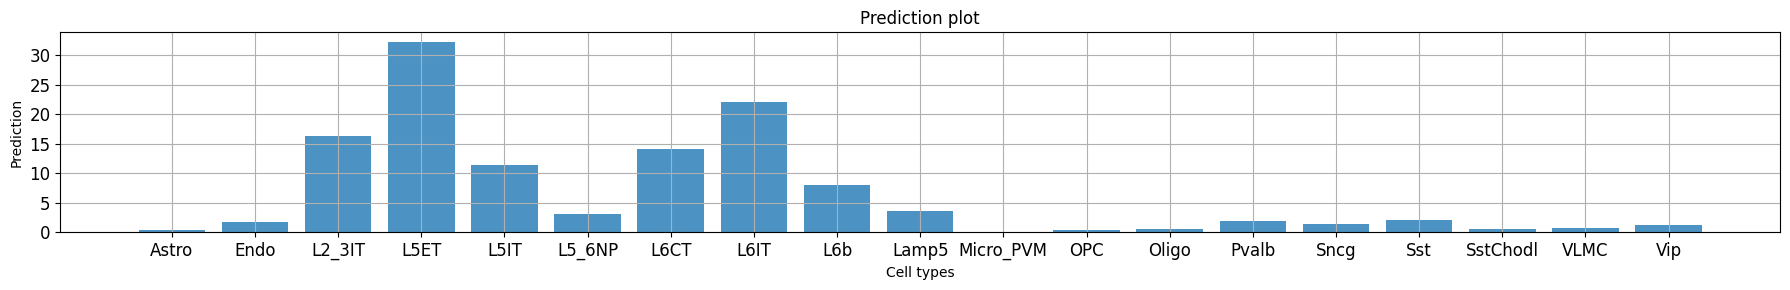

In [35]:
%matplotlib inline
# ensure that our designed sequence scores high on our target class
prediction = crested.tl.predict(designed_sequences[0], model=model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

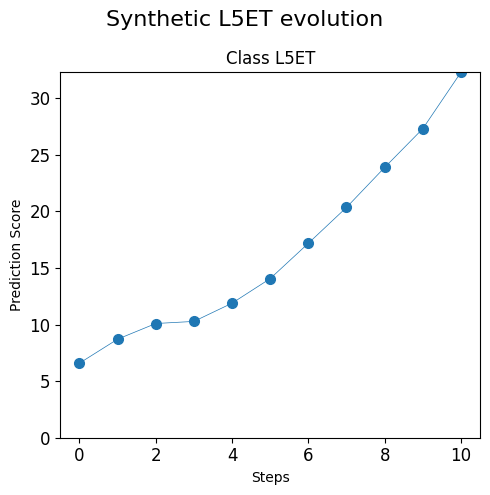

In [38]:
# plot the evolution of predictions
%matplotlib inline
crested.pl.patterns.enhancer_design_steps_predictions(
    intermediate_results,
    target_classes=["L5ET"],
    obs_names=list(adata.obs_names),
    seperate=True,
    title="Synthetic L5ET evolution",
    width=5,
    height=5,
)

In [ ]:
# there's a utility function to extract the intermediate sequences from the dict
intermed_seqs = crested.utils.derive_intermediate_sequences(intermediate_results)

# calculate contribution scores as usual
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    intermed_seqs[0],
    target_idx=class_idx,
    model=model,
)

2025-01-31T13:37:34.400925+0100 INFO Calculating contribution scores for 1 class(es) and 11 region(s).


Model: 100%|██████████| 1/1 [01:36<00:00, 96.75s/it]


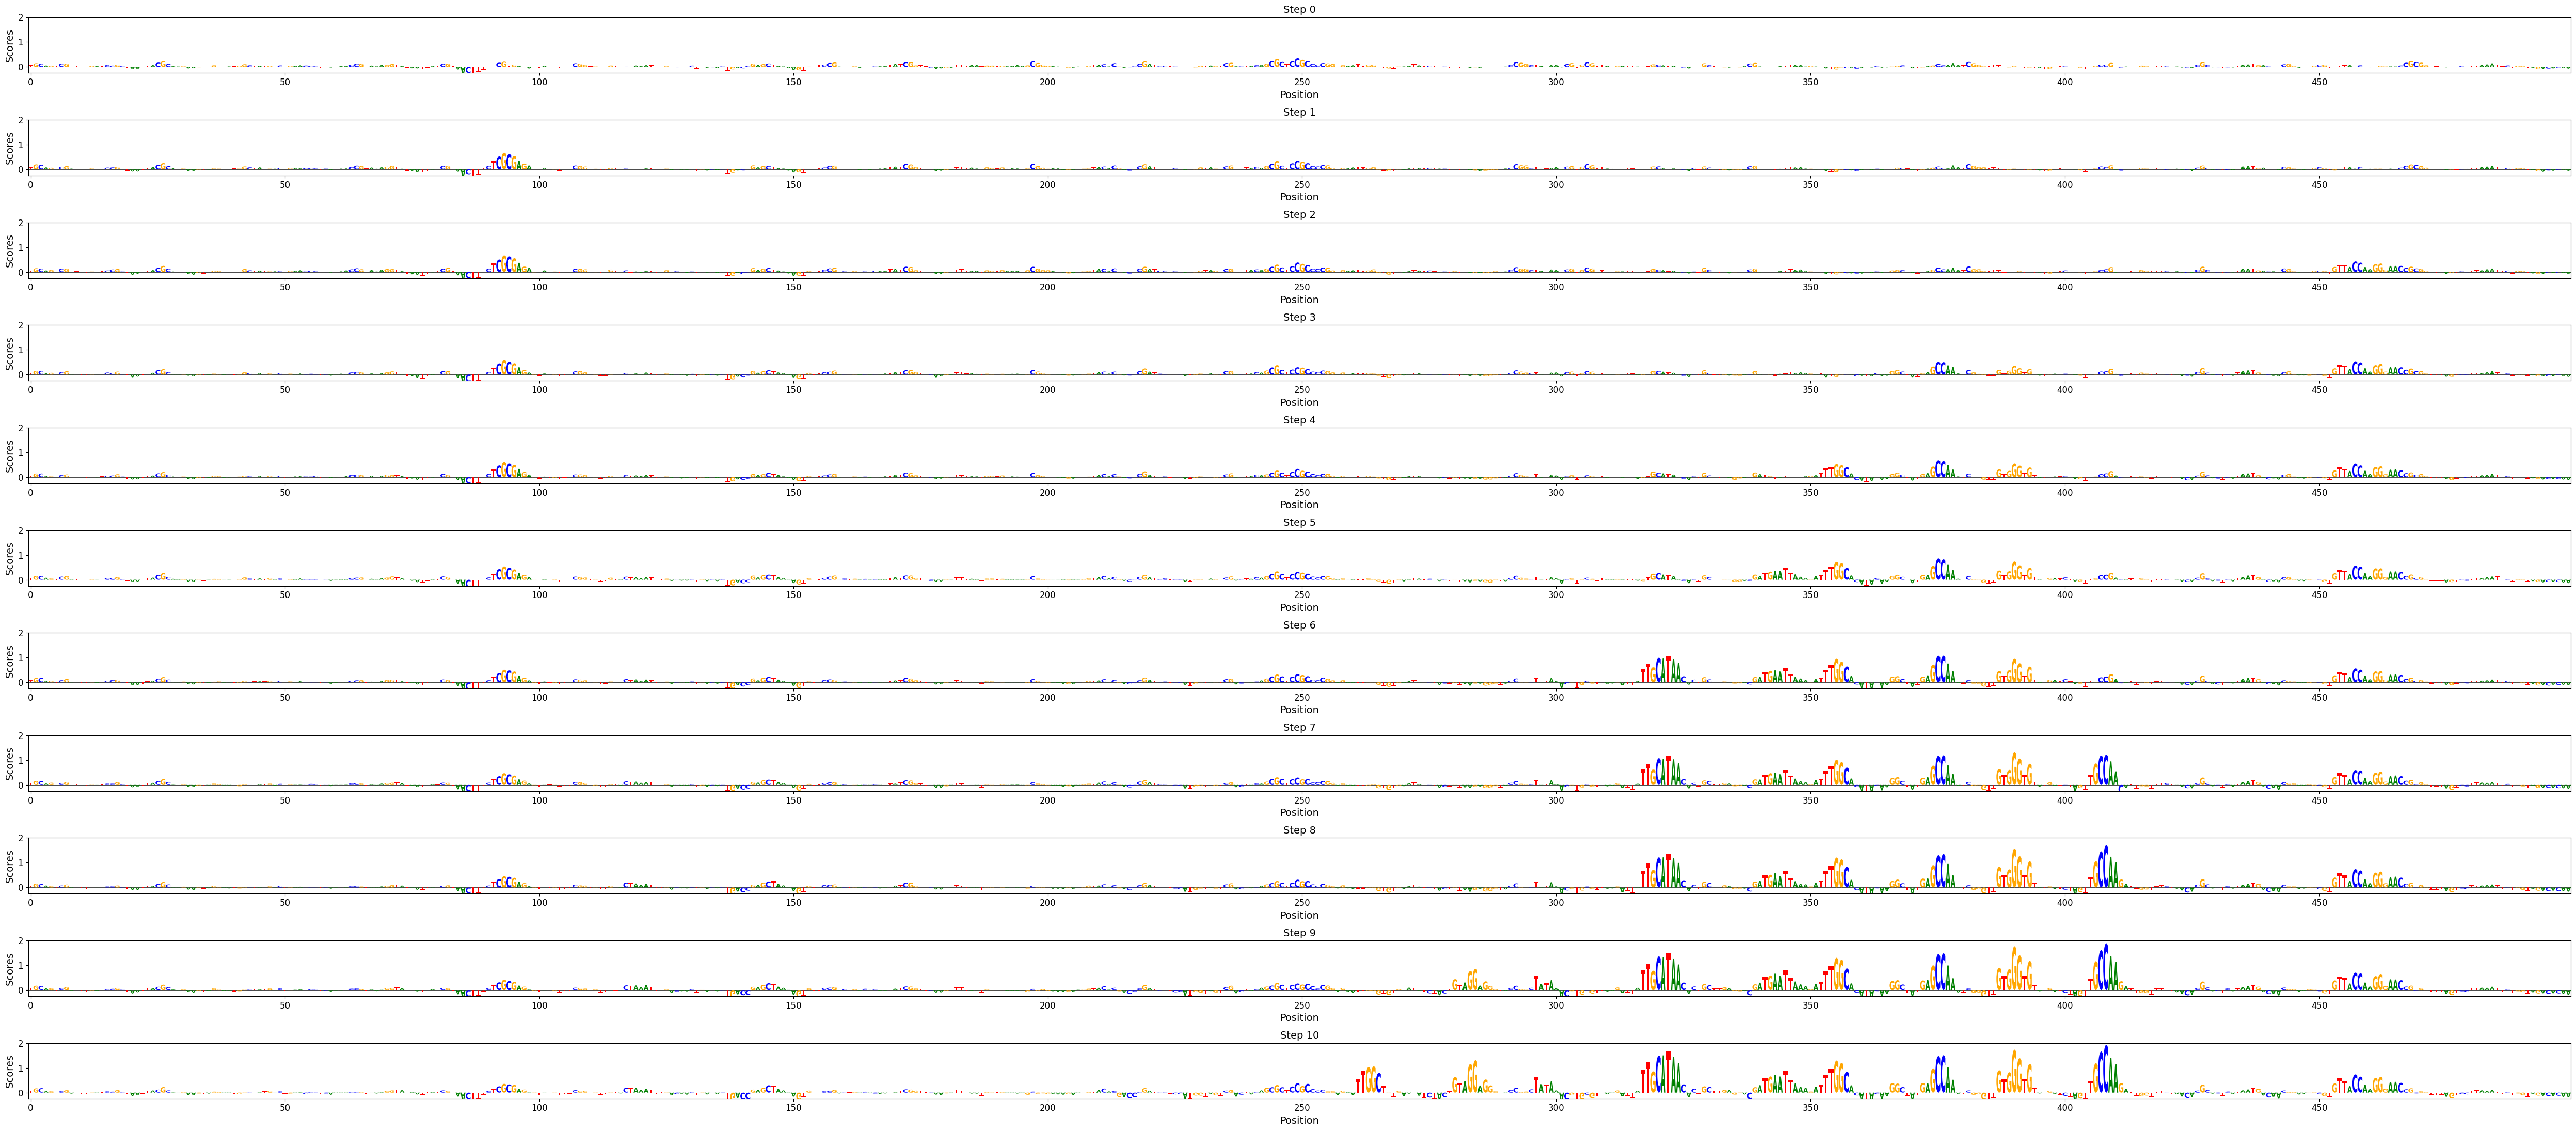

In [59]:
# you can use standard plotting to visualize the scores
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[f"Step {i}" for i in range(len(intermed_seqs[0]))],
    zoom_n_bases=500,
    ylim=(-0.25, 2),  # best to keep a constant scale for comparison
)

### Using custom optimizers in enhancer design

The default optimization function that is used in enhancer design is a weighted difference function that maximizes the increase in accessibility for a target cell type while penalizing an increase in accessibility for other cell types.  

This is just one option though, many use cases exist where you might want to optimize for something different. For example, you could write an optimization function that maximizes the cosine similarity between a given accessibility vector and the designed sequence predicted accessibility vector.  

Below we give an example on how to write such a custom optimization function, wherein we will try to reach a specific accessibily value for some target cell type relative to other related cell types using the L2 distance.

By default, the {class}`~crested.utils.EnhancerOptimizer` expects an optimization function as input that has the arguments *mutated_predictions*, *original_predictions*, and *target*, and returns the index of the best mutated sequence. See its documentation for more information.

In [18]:
from sklearn.metrics import pairwise


def L2_distance(
    mutated_predictions: np.ndarray,
    original_prediction: np.ndarray,
    target: np.ndarray,
    classes_of_interest: list[int],
):
    """Calculate the L2 distance between the mutated predictions and the target class"""
    if len(original_prediction.shape) == 1:
        original_prediction = original_prediction[None]
    L2_sat_mut = pairwise.euclidean_distances(
        mutated_predictions[:, classes_of_interest],
        target[classes_of_interest].reshape(1, -1),
    )
    L2_baseline = pairwise.euclidean_distances(
        original_prediction[:, classes_of_interest],
        target[classes_of_interest].reshape(1, -1),
    )
    return np.argmax((L2_baseline - L2_sat_mut).squeeze())


L2_optimizer = crested.utils.EnhancerOptimizer(optimize_func=L2_distance)

target_cell_type = "L2_3IT"

classes_of_interest = [
    i
    for i, ct in enumerate(adata.obs_names)
    if ct in ["L2_3IT", "L5ET", "L5IT", "L6IT"]
]
target = np.array([20 if x == target_cell_type else 0 for x in adata.obs_names])
intermediate, designed_sequences = crested.tl.enhancer_design_in_silico_evolution(
    model=model,
    target=target,  # our optimization function now expects a target vector instead of a class index
    n_sequences=1,
    n_mutations=30,
    enhancer_optimizer=L2_optimizer,
    return_intermediate=True,
    no_mutation_flanks=(807, 807),
    acgt_distribution=acgt_distribution,
    classes_of_interest=classes_of_interest,  # additional kwargs will be passed to the optimizer
)

100%|██████████| 30/30 [03:07<00:00,  6.26s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


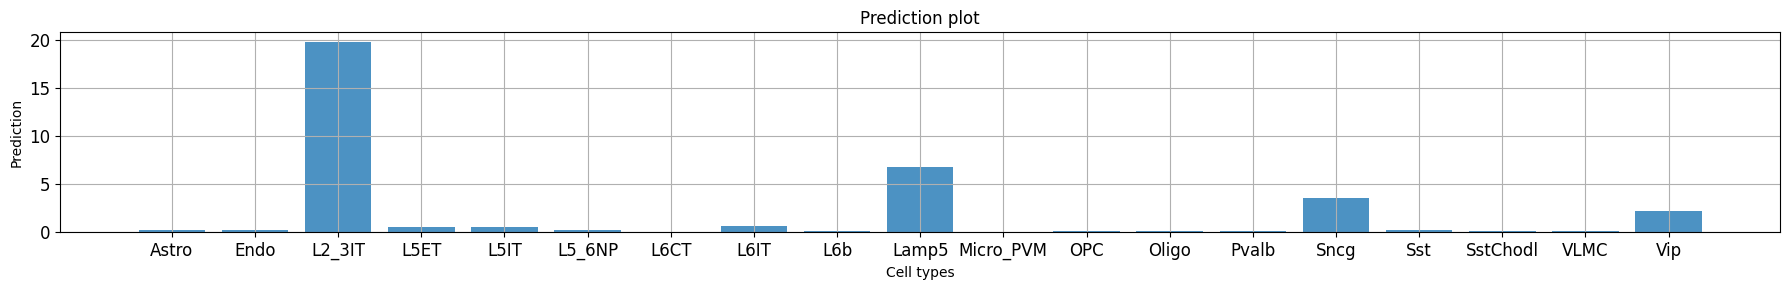

In [19]:
idx = 0
prediction = crested.tl.predict(designed_sequences[idx], model=model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

In [23]:
class_idx = list(adata.obs_names.get_indexer(["L2_3IT", "L5ET", "L5IT", "L6IT"]))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences[idx],
    target_idx=class_idx,
    model=model,
)

2025-01-31T10:56:43.914682+0100 INFO Calculating contribution scores for 4 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:34<00:00, 34.95s/it]


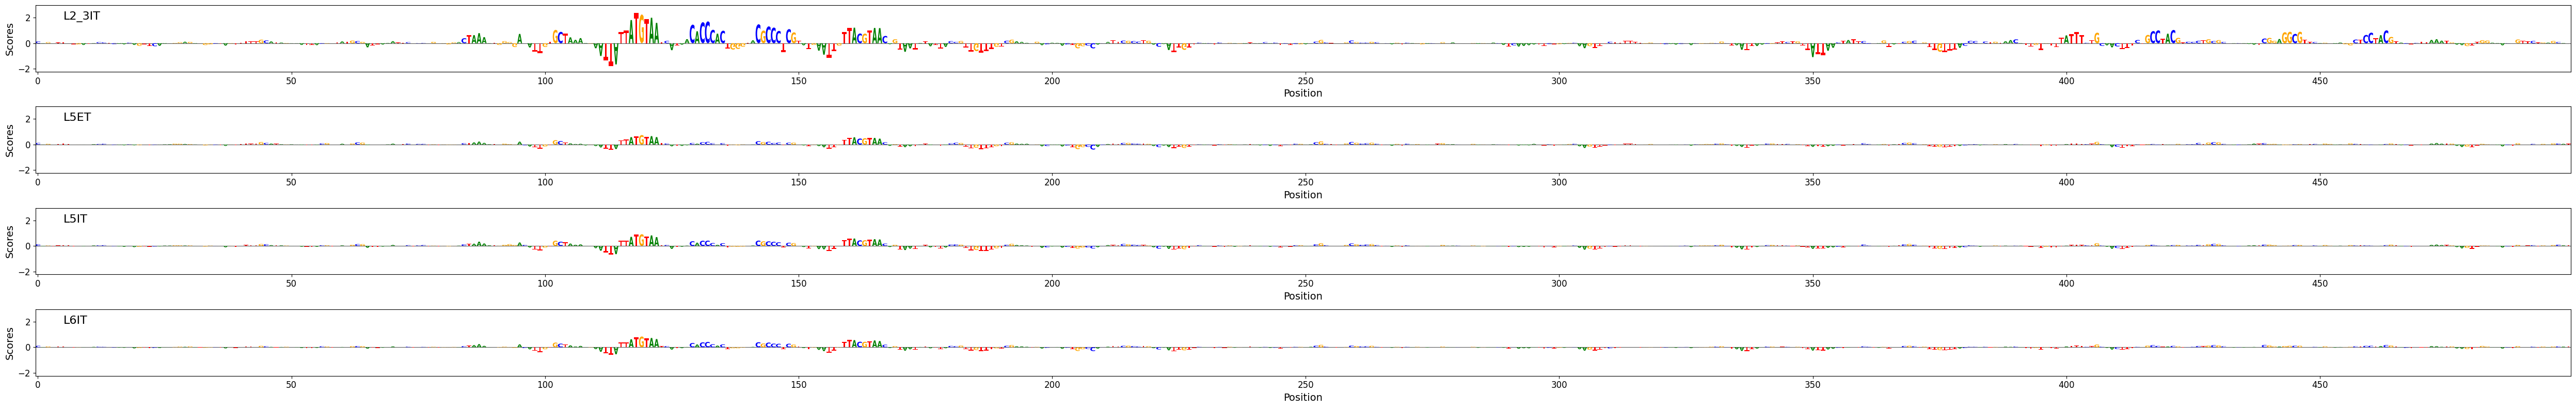

In [24]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["L2_3IT", "L5ET", "L5IT", "L6IT"],
    zoom_n_bases=500,
    title="",
)